# Result parser

In [1]:
from collections import defaultdict

index_cols = defaultdict(int)
index_cols.update({
    "r-gitto-rank":1,
    'r-gitto-sirank':1,
    'r-heartsvg': 1,
    'somde':3,
    'spatialde':3,
})

p_use_columns = {
    "geary":"pval_norm_fdr_bh",
    "moran":"pval_norm_fdr_bh",
    "r-gitto-rank":"adj.p.value",
    "r-sparkx":"adjustedPval",
    'somde':'qval',
    'spatialde':'qval',
    'spanve-d':'fdrs',
    'spanve-k':'fdrs',
    'r-heartsvg': 'p_adj',
    'r-meringue': 'p.adj',
    'r-spagene': 'adjp',
    'scgco': 'fdr',
    'p.spanve-d':'fdrs',
    'p.spanve-k':'fdrs'
}

score_use_columns = {
    'r-gitto-sirank':'scores',
    'sepal':'average',
    'cell_ranger':'dispersions_norm'
}

import os
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as chscore
from sklearn.metrics import davies_bouldin_score as dbscore
from sklearn.metrics import silhouette_score as siscore
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests

result_dir = "./recode/10XGenomics/"
data_ids = os.listdir(result_dir)
softs = [
    'spanve-k','spanve-d',
    'somde', 'cell_ranger',
    'moran','geary',
    'r-sparkx','r-gitto-rank','sepal',
    'r-gitto-sirank','spatialde',#'p.spanve-k','p.spanve-d',
    'r-heartsvg', #'r-meringue', 
    'r-spagene', 'scgco'
]

def parse_file(data_dir,soft):
    path = os.path.join(result_dir,data_dir,soft)
    try:
        file = [i for i in os.listdir(path) if i.endswith('csv')][0]
    except:
        print(data_dir,soft,'have no result file.')
        return None
    file = os.path.join(path,file)
    if soft not in p_use_columns:
        use_col = score_use_columns[soft]
    elif soft in p_use_columns:
        use_col = p_use_columns[soft]
    else: print(soft)
    
    df = pd.read_csv(file,index_col=index_cols[soft])
    if soft in ['moran','geary']:
        _0, fdrs, _1, _2, = multipletests(df['pval_norm'].fillna(1), method='fdr_bh')
        df[use_col] = fdrs
    df = df[use_col]
    df.index.name = 'genes'
    df = df.reset_index().groupby(by='genes').mean().iloc[:,0]
    df.name = soft
    return df

In [ ]:
from tqdm import tqdm

def evaluate_genesets_ch(adata,genes):
    if len(genes)==0: return None,None
    ground = adata.obs['cluster'].dropna()
 
    temp_data = adata[ground.index,genes].X.toarray()
    if (temp_data==0).all():
        return 0,np.nan

    score1 = chscore(temp_data,ground.values)
    score2 = dbscore(temp_data,ground.values)
    return score1,score2

np.random.seed(2)
df_metrics = pd.DataFrame(columns=['soft','data','n_sig','s1','s2'])
for data_id in tqdm(data_ids):
    
    adata = sc.read_h5ad(f'./data/10XGenomics/{data_id}')

    sc.pp.normalize_total(
        adata,
        target_sum=1e6
    )
    sc.pp.log1p(adata)
    adata.X = (adata.X - adata.X.mean(0)) / (adata.X.std(0)+1e-7)
    
    df_datares = pd.concat(
        [parse_file(data_id,soft) for soft in softs],
        axis=1
    )
    
    nmin = 100 # too less genes has not reference value
    nmax = 1000 # too many genes decline the performance of all methods
    nscore = int(0.1*df_datares.shape[0])
    
    for soft in df_datares.columns:
        if soft in p_use_columns:
            genes = df_datares.index[df_datares[soft]<0.05]
            if len(genes) > nmax:
                genes = df_datares[soft].sort_values().index[0:nmax]
            if len(genes) < nmin:
                genes = df_datares[soft].sort_values().index[0:nmin]
            s1,s2 = evaluate_genesets_ch(adata,genes)
            df_metrics.loc[len(df_metrics),:] = soft,data_id,genes.size,s1,s2
        elif soft in score_use_columns:
            genes = df_datares[soft].sort_values(ascending=False).index[0:nscore]
            s1,s2 = evaluate_genesets_ch(adata,genes)
            df_metrics.loc[len(df_metrics),:] = soft,data_id,genes.size,s1,s2

  0%|          | 0/43 [00:03<?, ?it/s]


In [ ]:
# --- saving block --- #
df_metrics['soft'] = df_metrics['soft'].map(
    {
        'spanve-k':'Spanve-k',
        'spanve-d':'Spanve-d',
        # 'p.spanve-k':'Spanve-k(with preprocess)',
        # 'p.spanve-d':'Spanve-d(with preprocess)',
        'somde':'SOMDE',
        'moran':'Moran test',
        'geary':'Geary test',
        'r-sparkx':'SPARK-X',
        'r-gitto-rank':'Giotto-Rank',
        'sepal':'sepal*',
        'r-gitto-sirank':'Giotto-siRank*',
        'spatialde':'SpatialDE',
        'cell_ranger': 'HVG*',
        'r-heartsvg': 'heartSVG',  
        'r-spagene': 'SpaGene', 
        'scgco': 'scGCO'
    }
)
df_metrics['data_abbr.'] = df_metrics['data'].apply(lambda text: ''.join([i[0] for i in text.split('_')]))
df_metrics.columns = ['soft','data','number of SV genes','CH index','DB index','Data Abbr.']
df_metrics['data'] =[i.replace('.h5ad','')[:-5] for i in df_metrics['data']]
df_metrics.to_csv('./Results/10XGenomics_metrics.csv',index=False)

# Visuliz

In [2]:
df_metrics = pd.read_csv('./Results/10XGenomics_metrics.csv')

In [3]:
df_metrics.head()

,soft,data,number of SV genes,CH index,DB index,Data Abbr.
0,Spanve-k,CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma,1000,486.204284,4.968868,C1FHOC
1,Spanve-d,CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma,1000,479.321339,4.695173,C1FHOC
2,SOMDE,CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma,1000,392.398971,4.296416,C1FHOC
3,HVG*,CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma,1808,112.890492,5.808460,C1FHOC
4,Moran test,CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma,1000,178.092837,6.339473,C1FHOC


In [3]:
df_metrics_copy = df_metrics.copy()

In [ ]:
df_metrics_copy['soft'] = df_metrics_copy['soft'].map(
    {
        'spanve-k':'Spanve-k',
        'spanve-d':'Spanve-d',
        # 'p.spanve-k':'Spanve-k',
        # 'p.spanve-d':'Spanve-d',
        'somde':'SOMDE',
        'moran':'Moran test',
        'geary':'Geary test',
        'r-sparkx':'SPARK-X',
        'r-gitto-rank':'Giotto-Rank',
        'sepal':'sepal*',
        'r-gitto-sirank':'Giotto-siRank*',
        'spatialde':'SpatialDE',
        'cell_ranger': 'HVG*'
    }
)

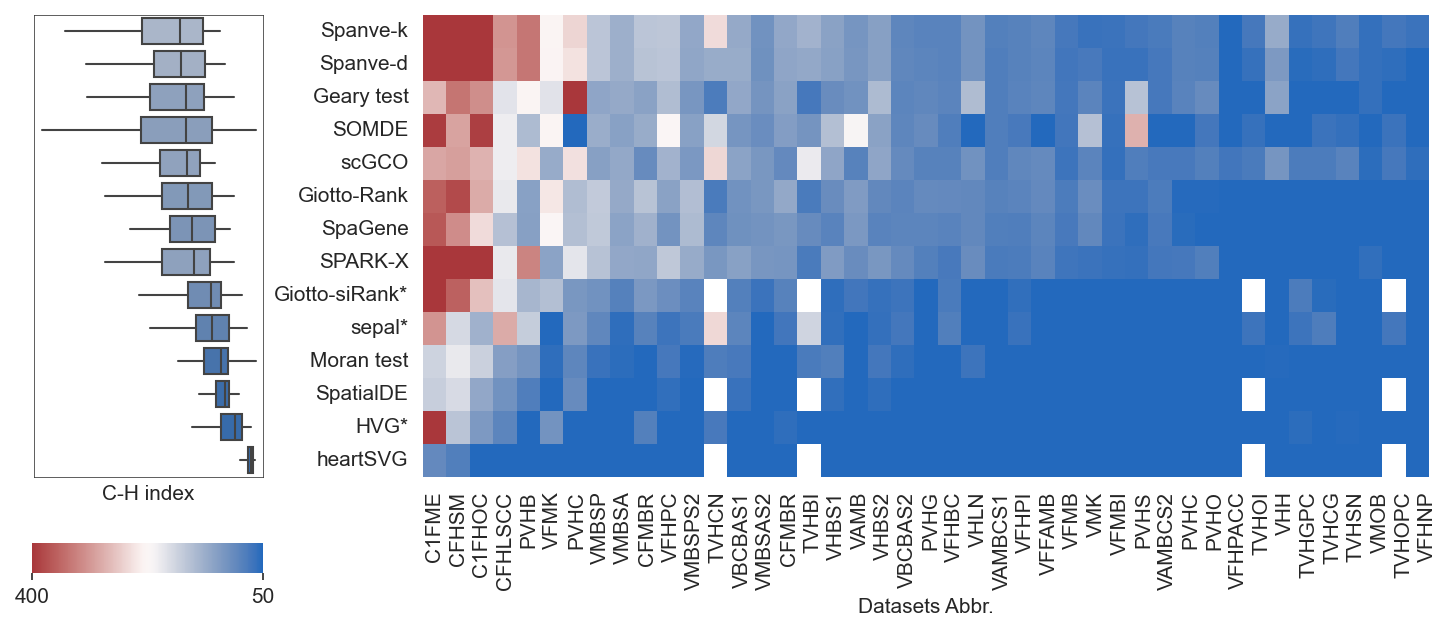

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style='white')
plt.rcParams['axes.linewidth'] = 0.35

def data_id_trans(text):
    r = ''.join([i[0] for i in text.split('_')])
    return r

platte = 'vlag'
plot_metric = 'CH index'
df_vis = df_metrics.groupby(['data','soft']).apply(lambda x:x[plot_metric].values[0]).unstack().T

color_map = sns.color_palette(platte,as_cmap=True)
soft_order = df_vis.median(axis=1).sort_values(ascending=False).index
data_order = df_vis.median().sort_values(ascending=False).index
df_vis = df_vis.loc[soft_order,data_order]

fig = plt.figure(dpi=150,figsize=(12,4))
fig.subplots_adjust(wspace=0.7)
spec = fig.add_gridspec(1, 4)
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1:])
cax = fig.add_axes((0.124,-0.05,0.128,0.05))
vmax = 400
vmin = 50

sns.heatmap(
    df_vis,ax=ax1,
    cmap=color_map,
    vmax = vmax,vmin=vmin,
    cbar_ax = cax,
    cbar_kws = {'orientation':'horizontal'}
)
cax.set_xticks([vmin,vmax])
cax.invert_xaxis()
ax1.set_xticks(0.5+1.01*np.arange(len(data_order)))
_=ax1.set_xticklabels([data_id_trans(i) for i in data_order],rotation=90)
ax1.set_ylabel('')
ax1.set_xlabel('Datasets Abbr.')

sns.boxplot(
    y='soft',x=plot_metric,
    orient='h',
    data=df_metrics,
    order=soft_order,
    ax =ax0,
    linewidth=1,fliersize=0,
    saturation=0.75,
    palette={
        soft:sns.color_palette(platte,as_cmap=True)((v-vmin)/(vmax-vmin),alpha=0.7) #
        for soft,v in df_vis.mean(axis=1).sort_values(ascending=False).to_dict().items()
    },
    showcaps=False
)

ax0.set_xlim(-10,300)
ax0.set_xticks([])
ax0.invert_xaxis()
ax0.set_yticklabels([])
ax0.set_ylabel('')
ax0.set_xlabel('C-H index')
# sns.despine(ax=ax0, top=True, left=True, right=False)
fig.savefig('./Results/10XGenomicx_CHIdx_V21.pdf',bbox_inches='tight')